In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import math
import seaborn as sns
import re
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn.tree import DecisionTreeClassifier



In [2]:
df_tr = pd.read_csv("transactions_mix.csv")
df_sb = pd.read_csv("subscriptions_mix.csv")
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)



/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_8305/1759685970.py:1: DtypeWarning: Columns (4,6,10,13,14,15,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tr = pd.read_csv("transactions_mix.csv")
/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_8305/1759685970.py:2: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb = pd.read_csv("subscriptions_mix.csv")


### Data Clean & Visualization

In [3]:
na_count = df_tr.isna().sum()
na_count

id                         0
created_at                 0
country                    0
operator                   0
service                    0
source                  1356
msisdn                     0
event                      0
event_date                 0
cycle                      0
revenue                    0
currency                1356
charge_date                0
publisher             201356
handset               244004
browser               201358
trxid                 304647
telco_api_url          14352
telco_api_response     42113
sms_content           305428
status_sms            304072
dtype: int64

In [4]:

cols_drop = [
    'publisher',
    'handset',
    'browser',
    'trxid',
    'telco_api_url',
    'telco_api_response',
    'sms_content',
    'status_sms'
]
df_tr.drop(cols_drop, axis=1, inplace=True)

imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
imputer = imputer.fit(df_tr)
df_tr = pd.DataFrame(imputer.transform(df_tr), columns = df_tr.columns)
df_tr.isnull().sum()


id             0
created_at     0
country        0
operator       0
service        0
source         0
msisdn         0
event          0
event_date     0
cycle          0
revenue        0
currency       0
charge_date    0
dtype: int64

In [5]:
cnt_na = df_sb.isna().sum()
cnt_na

id                        0
created_at                0
country                   0
operator                  0
service                   0
source                  604
msisdn                    0
status                    0
cycle                     0
adnet                161443
revenue                   0
subs_date                 0
renewal_date              0
freemium_end_date    108911
unsubs_from          245453
unsubs_date          204626
service_price             0
currency               5721
profile_status        27397
publisher            197964
trxid                188763
pixel                219888
handset              211738
browser              208785
attempt_charging          0
success_billing           0
dtype: int64

In [6]:
cols_drop = {
    'publisher',
    'trxid',
    'pixel',
    'handset',
    'unsubs_from',
    'browser',
    'adnet',
}

df_sb.drop(cols_drop, axis=1, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_sb)
df_sb = pd.DataFrame(imputer.transform(df_sb), columns = df_sb.columns)
df_sb.isna().sum()


id                   0
created_at           0
country              0
operator             0
service              0
source               0
msisdn               0
status               0
cycle                0
revenue              0
subs_date            0
renewal_date         0
freemium_end_date    0
unsubs_date          0
service_price        0
currency             0
profile_status       0
attempt_charging     0
success_billing      0
dtype: int64

In [7]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,revenue,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency,profile_status,attempt_charging,success_billing
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,2023-08-03 14:12:59.000,6,BATH,Active,15,0
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,2023-08-03 14:12:59.000,6,BATH,Active,15,0
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,1,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,2023-08-03 14:12:59.000,6,BATH,Active,1,1
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,2023-08-03 14:12:59.000,6,BATH,Active,5,0
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,2023-08-03 14:12:59.000,6,BATH,Active,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,2022-10-15 00:00:00.000,0001-01-01 00:00:00.000,300,Rial,Active,1,0
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,2022-10-15 00:00:00.000,0001-01-01 00:00:00.000,300,Rial,Active,1,0
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,2022-10-15 00:00:00.000,0001-01-01 00:00:00.000,300,Rial,Active,1,0
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,2022-10-15 00:00:00.000,0001-01-01 00:00:00.000,300,Rial,Active,1,0


In [8]:
df_sb['subs_date'] = df_sb['subs_date'].astype(str)
df_sb['subs_date'] = df_sb['subs_date'].str.split().str[0]
df_sb['renewal_date'] = df_sb['renewal_date'].astype(str)
df_sb['renewal_date'] = df_sb['renewal_date'].str.split().str[0]
df_sb['unsubs_date'] = df_sb['unsubs_date'].str.split().str[0]


In [9]:
df_sb['subs_date'] = pd.to_datetime(df_sb['subs_date'])
df_sb['renewal_date'] = pd.to_datetime(df_sb['renewal_date'], errors='coerce')

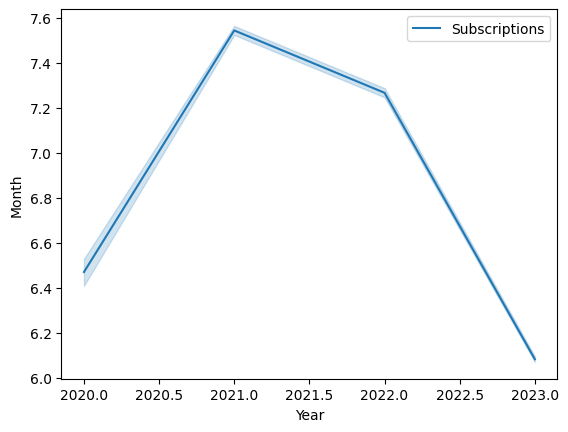

In [10]:
df_sb["Subs_Year"] = df_sb["subs_date"].dt.year
df_sb["Subs_Month"] = df_sb["subs_date"].dt.month
# df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
# df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month

sns.lineplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions")
# sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
plt.xlabel('Year')
plt.ylabel('Month')
plt.legend()
plt.show()


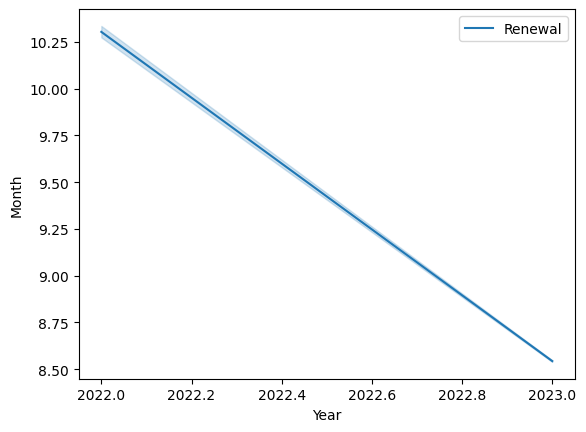

In [11]:
df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month
sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
plt.xlabel('Year')
plt.ylabel('Month')
plt.legend()
plt.show()

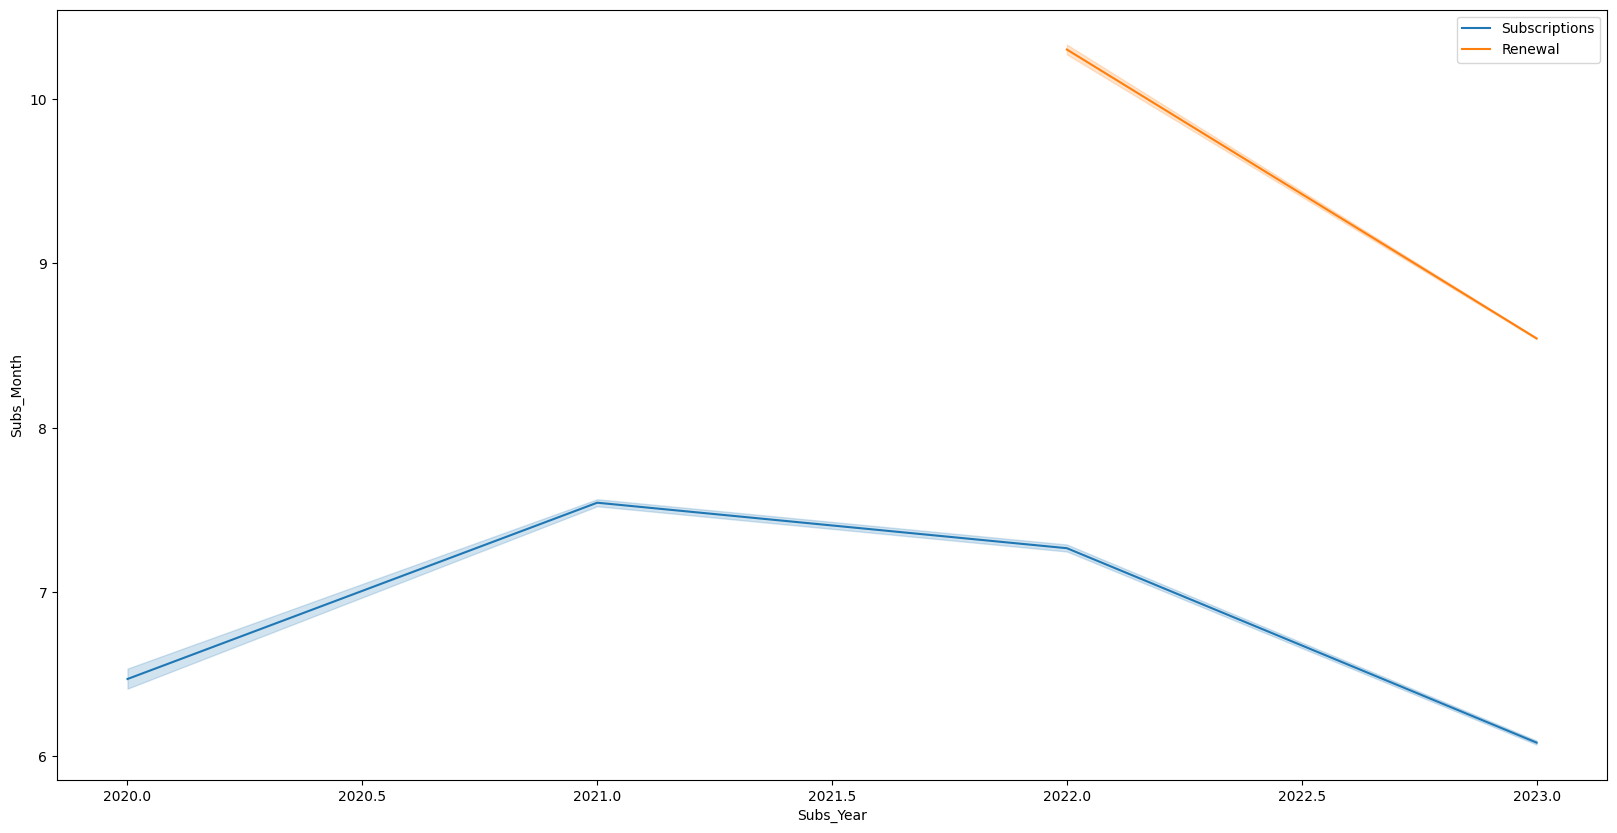

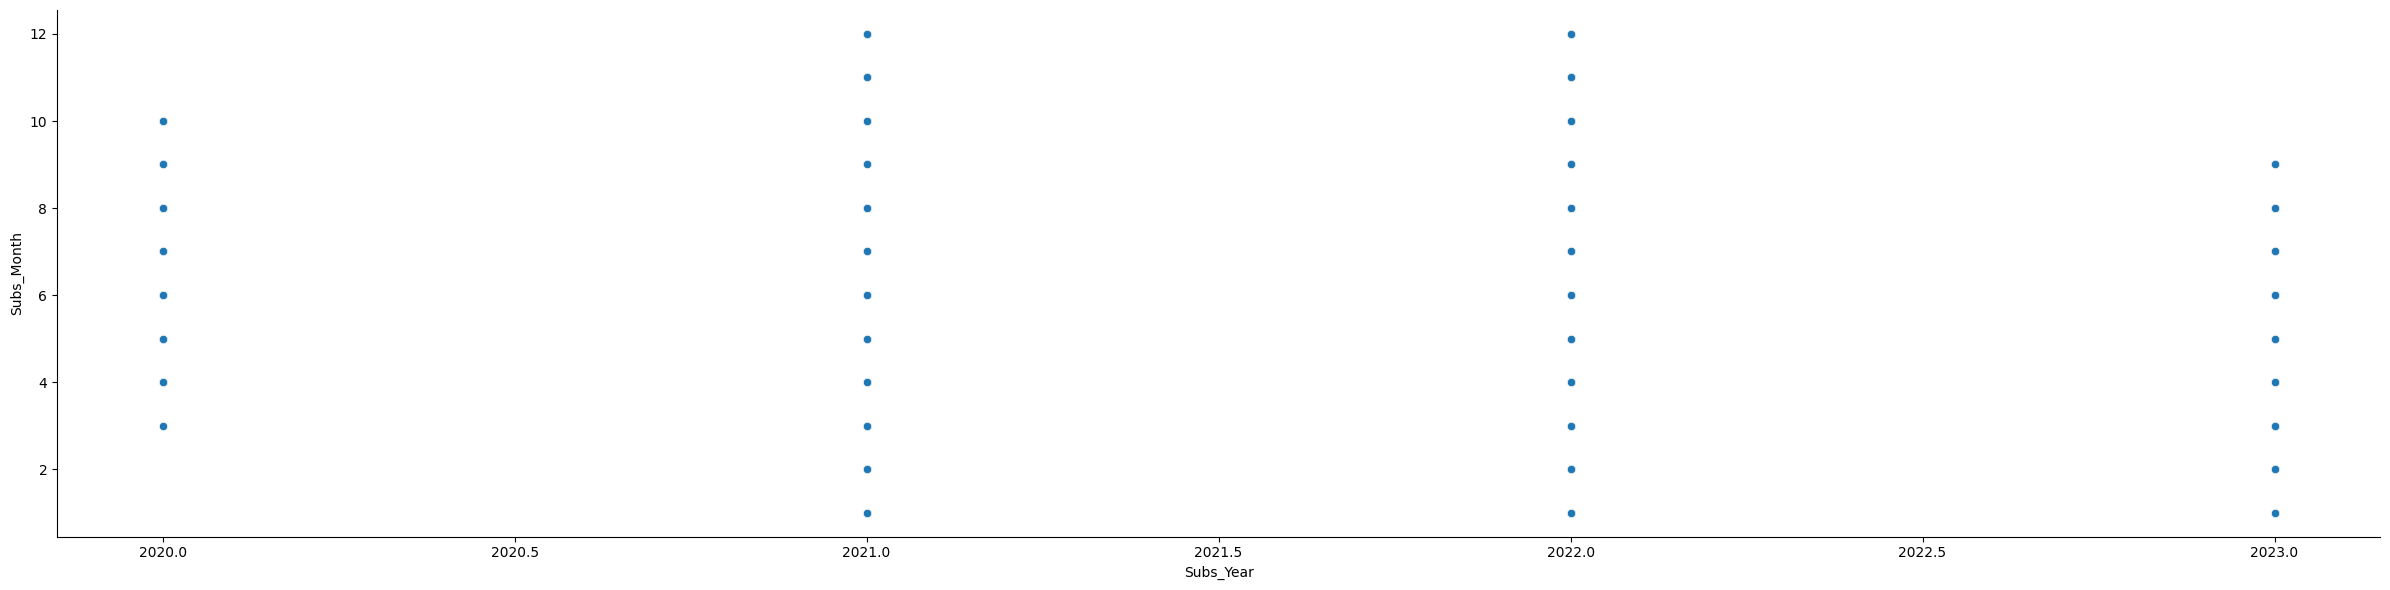

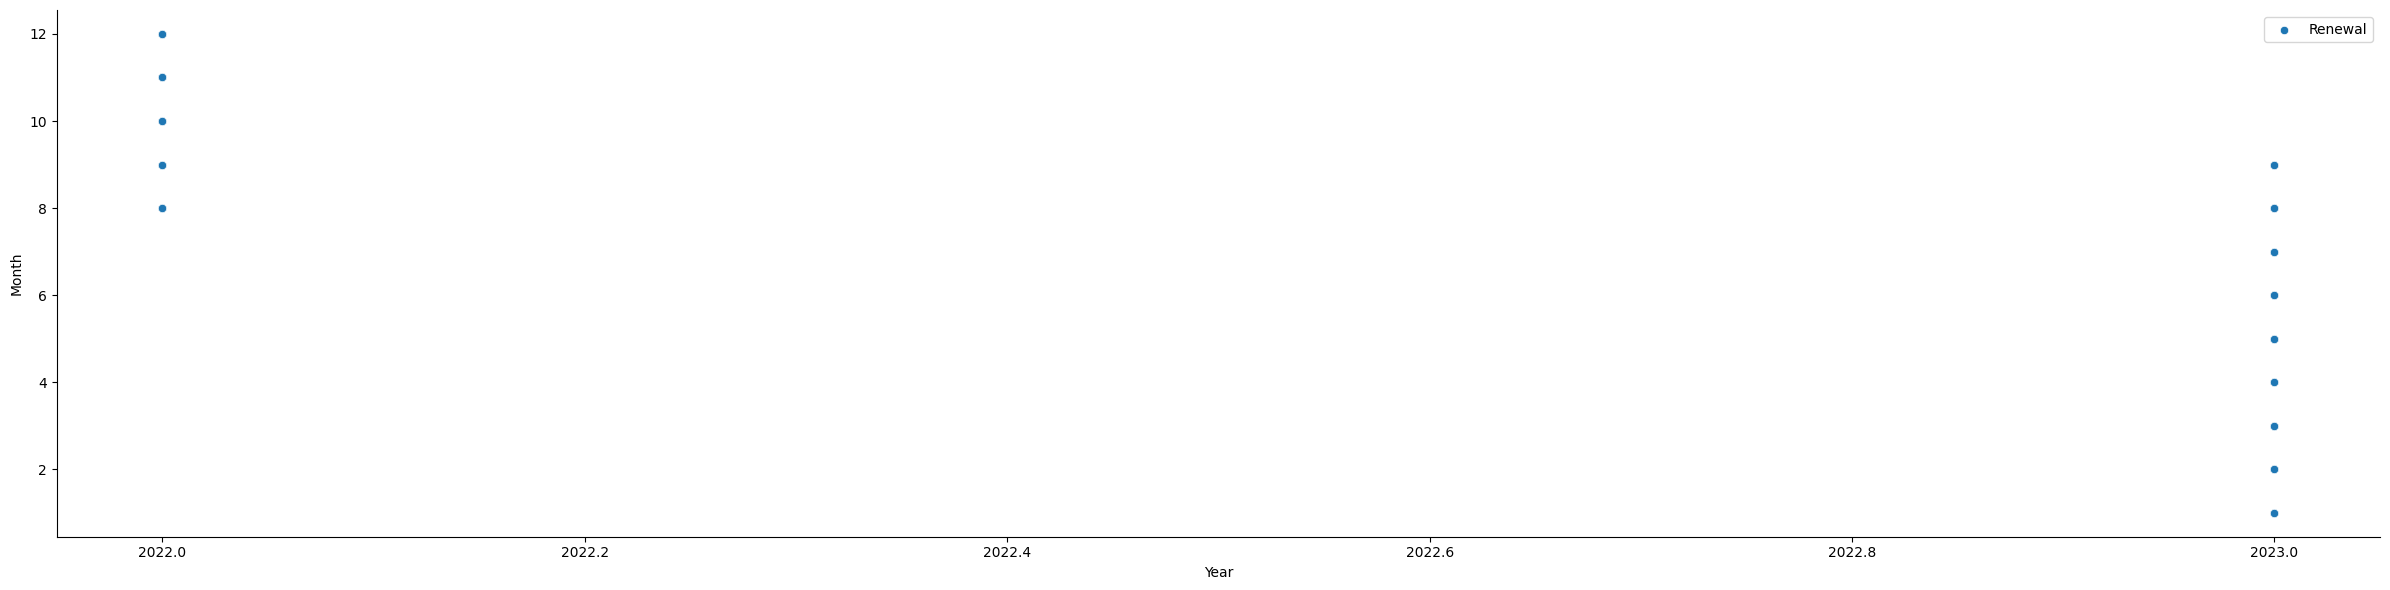

In [12]:
df_sb["Subs_Year"] = df_sb["subs_date"].dt.year
df_sb["Subs_Month"] = df_sb["subs_date"].dt.month
df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month


fig = plt.subplots(figsize=(20, 10))
sns.lineplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions")
sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
sns.relplot(data=df_sb, x="Subs_Year",y="Subs_Month",label="Subscriptions", height=6, aspect=4)
sns.relplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal",height=6, aspect=4)
plt.xlabel('Year')
plt.ylabel('Month')
plt.legend()
plt.show()


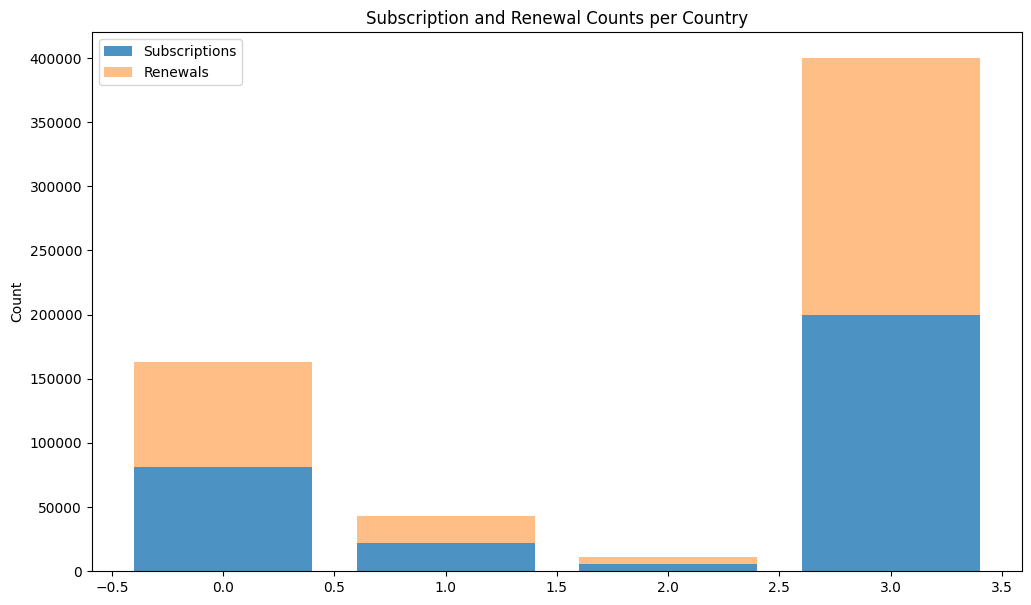

In [13]:
subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
renewals_count = df_sb.groupby('country').size().reset_index(name='Renewal_Count')
subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer').fillna(0)
plt.figure(figsize=(12, 7))
countries = subs_renewals_per_country['country']
y_pos = range(len(countries))
subscription_counts = subs_renewals_per_country['Subscription_Count']
renewal_counts = subs_renewals_per_country['Renewal_Count']

plt.bar(y_pos, subscription_counts, align='center', alpha=0.8, label='Subscriptions')
plt.bar(y_pos, renewal_counts, align='center', alpha=0.5, label='Renewals', bottom=subscription_counts)

# plt.xticks(y_pos, countries)
plt.ylabel('Count')
plt.title('Subscription and Renewal Counts per Country')
plt.legend()

plt.show()

In [14]:
df_sb['subs_date'].max()

Timestamp('2023-09-14 00:00:00')

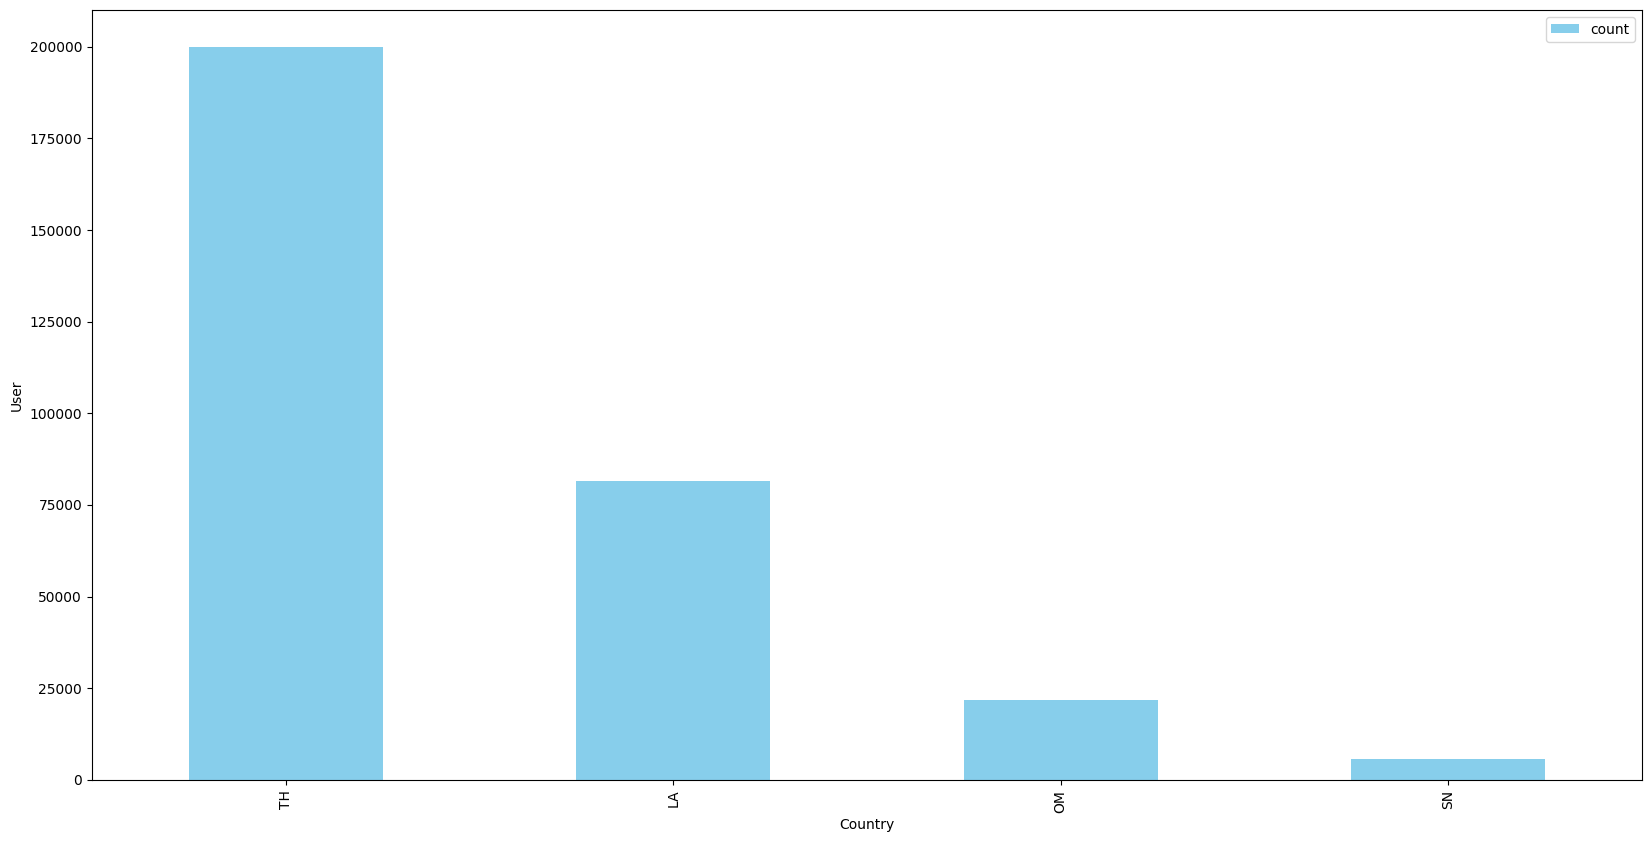

In [15]:
countries = df_sb['country'].value_counts()
topCountries = countries.head(20)
fig = plt.subplots(figsize=(20, 10))

topCountries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('User')
plt.legend()
plt.show()

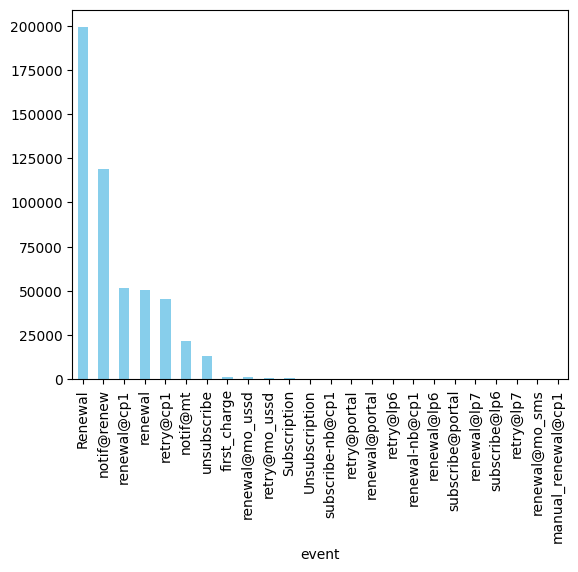

In [16]:
event_cnt = df_tr['event'].value_counts()
event_cnt.plot(kind='bar',color='skyblue')
plt.xticks(rotation=90)
plt.show()

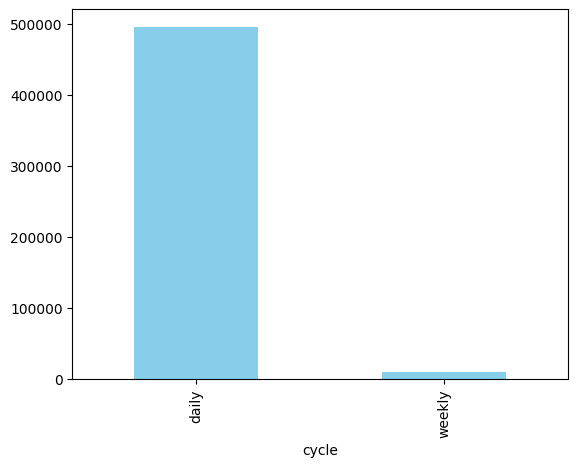

In [17]:
cycle_cnt = df_tr['cycle'].value_counts()
cycle_cnt.plot(kind='bar',color='skyblue')
plt.show()

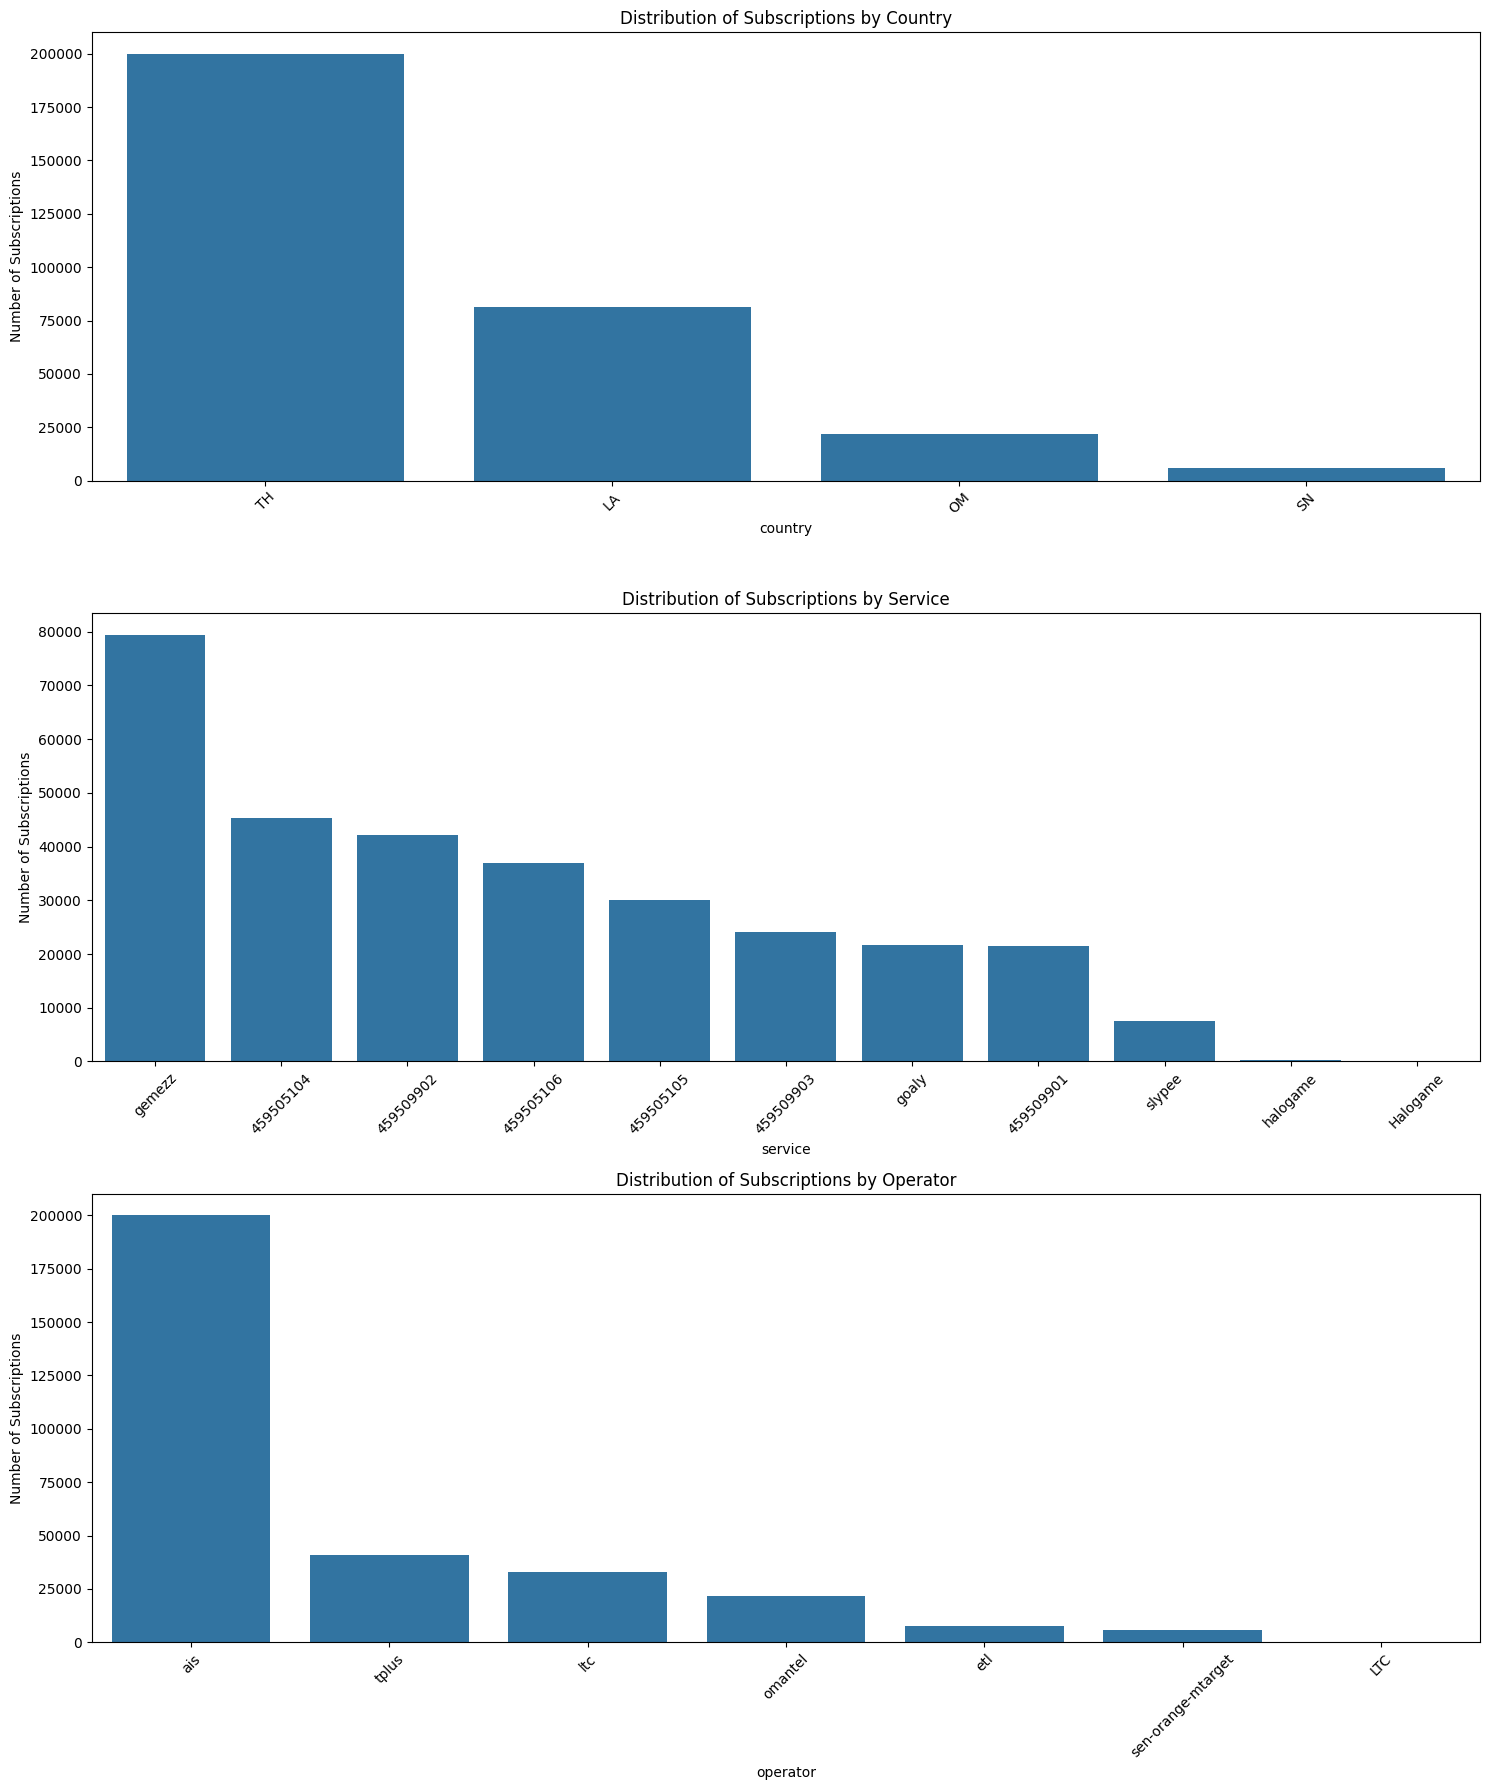

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

#Country
sns.countplot(data=df_sb, x='country', ax=axes[0], order=df_sb['country'].value_counts().index)
axes[0].set_title('Distribution of Subscriptions by Country')
axes[0].set_ylabel('Number of Subscriptions')
axes[0].tick_params(axis='x', rotation=45)

#Service
sns.countplot(data=df_sb, x='service', ax=axes[1], order=df_sb['service'].value_counts().index)
axes[1].set_title('Distribution of Subscriptions by Service')
axes[1].set_ylabel('Number of Subscriptions')
axes[1].tick_params(axis='x', rotation=45)

#Operator
sns.countplot(data=df_sb, x='operator', ax=axes[2], order=df_sb['operator'].value_counts().index)
axes[2].set_title('Distribution of Subscriptions by Operator')
axes[2].set_ylabel('Number of Subscriptions')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [19]:
df_merge = df_tr.merge(df_sb, how='inner', on=('msisdn', 'msisdn'))



In [20]:
df_merge.drop('id_y', axis=1,inplace=True)


In [21]:
for col in df_merge.columns:
    if col.endswith('_x'):
        newName = col.replace('_x','_tr')
        df_merge.rename(columns={col: newName}, inplace=True)
    elif col.endswith('_y'):
        newName = col.replace('_y','_subs')
        df_merge.rename(columns={col: newName}, inplace=True)


In [22]:
df_merge['unsubs_date'] = pd.to_datetime(df_merge['unsubs_date'], errors='coerce')


/var/folders/yg/gk3kh2hn45gb3sb4nslzjfy00000gn/T/ipykernel_8305/441547764.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_merge['unsubs_date'] = pd.to_datetime(df_merge['unsubs_date'], errors='coerce')


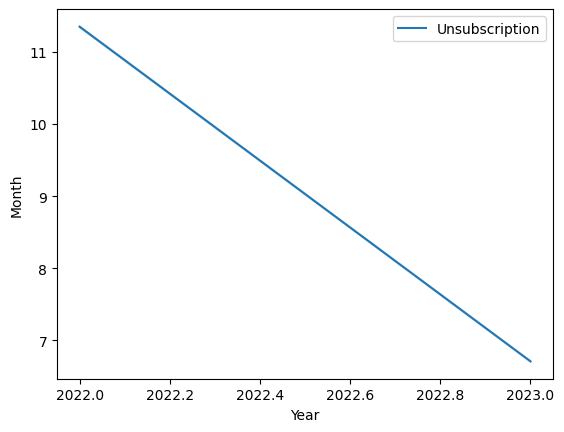

In [23]:
df_merge["Unsubs_year"] = df_merge["unsubs_date"].dt.year
df_merge["Unsubs_Month"] = df_merge["unsubs_date"].dt.month
# df_sb["Renew_Year"] = df_sb["renewal_date"].dt.year
# df_sb["Renew_Month"] = df_sb["renewal_date"].dt.month

sns.lineplot(data=df_merge, x="Unsubs_year",y="Unsubs_Month",label="Unsubscription")
# sns.lineplot(data=df_sb, x="Renew_Year",y="Renew_Month",label="Renewal")
plt.xlabel('Year')
plt.ylabel('Month')
plt.legend()
plt.show()


In [24]:
# subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
# renewals_count = df_sb[df_sb['renewal_date'].notna()].groupby('country').size().reset_index(name='Renewal_Count')
# subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer')

# subs_renewals_per_country

In [25]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_merge)
df_merge = pd.DataFrame(imputer.transform(df_merge), columns = df_merge.columns)


In [26]:
df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,cycle_tr,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,cycle_subs,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Subs_Year,Subs_Month,Renew_Year,Renew_Month,Unsubs_year,Unsubs_Month
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,daily,0:00,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150,BATH,Active,2,0,2023,8,2023.0,8.0,2023.0,8.0
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,daily,150:00:00,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,daily,0:00,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150,BATH,Active,1,0,2023,9,2023.0,8.0,2023.0,9.0
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,daily,150:00:00,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,daily,150,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150,BATH,Active,5,1,2023,7,2023.0,8.0,2023.0,8.0
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,daily,0:00,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150,BATH,Active,4,0,2023,8,2023.0,8.0,2023.0,8.0
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,daily,0:00,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,daily,0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150,BATH,Active,4,0,2023,8,2023.0,8.0,2023.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,daily,0,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023,9,2023.0,9.0,2023.0,9.0
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,daily,2000,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023,9,2023.0,9.0,2023.0,9.0
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,daily,2000,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023,9,2023.0,9.0,2023.0,9.0
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,daily,2000,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,daily,20000,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,2000:00:00,LAK,inactive,11,10,2023,9,2023.0,9.0,2023.0,9.0


In [27]:
# date_columns = ['created_at_tr', 'charge_date', 'created_at_subs', 'subs_date', 'renewal_date', 'freemium_end_date', 'unsubs_date']
# for col in date_columns:
#     df_merge[col] = pd.to_datetime(df_merge[col], errors='coerce')  # Set errors='coerce' to handle invalid dates

# Convert Currency Columns to Numerical
currency_columns = ['revenue_tr', 'revenue_subs', 'service_price']
for col in currency_columns:
    df_merge[col] = df_merge[col].str.replace('[^\d.]', '', regex=True).astype(float)

In [28]:
df_merge['profile_status'] = df_merge['profile_status'].str.upper()

In [29]:
# df_merge = pd.get_dummies(data=df_merge, columns=['cycle_tr','cycle_subs','profile_status'])




In [30]:
# df_merge['cycle_tr'] = df_merge['cycle_tr'].apply(lambda x : 0 if x == 'daily' else 1)
# df_merge['cycle_subs'] = df_merge['cycle_subs'].apply(lambda x : 0 if x == 'daily' else 1)
# df_merge['profile_status'] = df_merge['profile_status'].apply(lambda x : 1 if x == 'ACTIVE' else 0)

### Data Train

In [31]:
df_merge['cycle_tr'] = df_merge['cycle_tr'].apply(lambda x : 0 if x == 'daily' else 1)
df_merge['cycle_subs'] = df_merge['cycle_subs'].apply(lambda x : 0 if x == 'daily' else 1)


In [32]:
df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,cycle_tr,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,cycle_subs,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Subs_Year,Subs_Month,Renew_Year,Renew_Month,Unsubs_year,Unsubs_Month
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,0,0.0,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,2,0,2023,8,2023.0,8.0,2023.0,8.0
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,0,1500000.0,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,0,0.0,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150.0,BATH,ACTIVE,1,0,2023,9,2023.0,8.0,2023.0,9.0
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,0,1500000.0,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,0,150.0,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,5,1,2023,7,2023.0,8.0,2023.0,8.0
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,0,0.0,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023,8,2023.0,8.0,2023.0,8.0
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,0,0.0,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023,8,2023.0,8.0,2023.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,0,NaN,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,0,NaN,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,0,NaN,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,0,NaN,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,0,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0


In [33]:
df_merge = pd.get_dummies(data=df_merge, columns=['cycle_tr','cycle_subs'])


In [34]:
df_merge = df_merge.replace({True: 1, False: 0})

In [35]:
df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Subs_Year,Subs_Month,Renew_Year,Renew_Month,Unsubs_year,Unsubs_Month,cycle_tr_0,cycle_tr_1,cycle_subs_0,cycle_subs_1
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,0.0,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,2,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,1500000.0,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,0.0,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150.0,BATH,ACTIVE,1,0,2023,9,2023.0,8.0,2023.0,9.0,1,0,1,0
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,1500000.0,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,150.0,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,ACTIVE,5,1,2023,7,2023.0,8.0,2023.0,8.0,1,0,1,0
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,0.0,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,0.0,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,ACTIVE,4,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,NaN,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,NaN,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,NaN,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,NaN,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,INACTIVE,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0


In [36]:
from sklearn.calibration import LabelEncoder

df_merge['profile_status'] = LabelEncoder().fit_transform(df_merge['profile_status'])
# df_merge['source_subs'] = LabelEncoder().fit(df_merge['source_subs'])

# q = LabelEncoder().fit(df_merge['source_subs'])

df_merge

,id_tr,created_at_tr,country_tr,operator_tr,service_tr,source_tr,msisdn,event,event_date,revenue_tr,currency_tr,charge_date,created_at_subs,country_subs,operator_subs,service_subs,source_subs,status,revenue_subs,subs_date,renewal_date,freemium_end_date,unsubs_date,service_price,currency_subs,profile_status,attempt_charging,success_billing,Subs_Year,Subs_Month,Renew_Year,Renew_Month,Unsubs_year,Unsubs_Month,cycle_tr_0,cycle_tr_1,cycle_subs_0,cycle_subs_1
0,1,2023-09-13 16:50:38.933,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BsR34r8YUdKfebHXSuTd/2nE1guUkOBbxCZ...,renewal,2023-08-08 00:35:39.000,0.0,BATH,2023-08-08 00:35:39.000,2023-09-13 09:20:07.163,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,0,2,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
1,2,2023-09-13 16:50:38.936,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-3NE20RCOX+Ec9GA6Cqs4BkgX/gAVg7I/s7y...,renewal,2023-08-08 00:00:36.000,1500000.0,BATH,2023-08-08 00:00:36.000,2023-09-13 09:20:02.297,SN,sen-orange-mtarget,gemezz,sms,-1,0.0,2023-09-01,2023-08-08,2022-10-15 00:00:00.000,2023-09-01,150.0,BATH,0,1,0,2023,9,2023.0,8.0,2023.0,9.0,1,0,1,0
2,3,2023-09-13 16:50:38.937,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-BaTa5dR4N9wsaiR2h9dS5MVkxdYjZLbqzrq...,renewal,2023-08-08 00:03:18.000,1500000.0,BATH,2023-08-08 00:03:18.000,2023-09-13 09:20:06.775,SN,sen-orange-mtarget,gemezz,web,1,150.0,2023-07-29,2023-08-11,2022-10-15 00:00:00.000,2023-08-03,150.0,BATH,0,5,1,2023,7,2023.0,8.0,2023.0,8.0,1,0,1,0
3,4,2023-09-13 16:50:38.939,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:12.000,0.0,BATH,2023-08-08 01:09:12.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,0,4,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
4,55,2023-09-13 16:50:38.998,SN,sen-orange-mtarget,gemezz,cp1,PDKSUB-200-UMbSx6eLdzdjNjI3fVP1FHEuQItkj0Jk8rp...,renewal,2023-08-08 01:09:06.000,0.0,BATH,2023-08-08 01:09:06.000,2023-09-13 09:20:13.751,SN,sen-orange-mtarget,gemezz,web,0,0.0,2023-08-08,2023-08-08,2022-10-15 00:00:00.000,2023-08-14,150.0,BATH,0,4,0,2023,8,2023.0,8.0,2023.0,8.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401321,28005,2023-09-13 15:45:28.764,LA,etl,slypee,cp1,2022028975,renewal,2023-09-08 00:28:32.000,NaN,LAK,2023-09-08 00:28:32.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,1,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401322,31517,2023-09-13 15:45:30.909,LA,etl,slypee,cp1,2022028975,renewal,2023-09-09 00:25:55.000,NaN,LAK,2023-09-09 00:25:55.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,1,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401323,35154,2023-09-13 15:45:32.811,LA,etl,slypee,cp1,2022028975,renewal,2023-09-10 00:26:13.000,NaN,LAK,2023-09-10 00:26:13.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,1,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0
401324,38860,2023-09-13 15:45:34.717,LA,etl,slypee,cp1,2022028975,renewal,2023-09-11 00:26:39.000,NaN,LAK,2023-09-11 00:26:39.000,2023-09-13 08:08:57.903,LA,etl,slypee,cp1,-1,NaN,2023-09-02,2023-09-13,2022-10-15 00:00:00.000,2023-09-13,20000000.0,LAK,1,11,10,2023,9,2023.0,9.0,2023.0,9.0,1,0,1,0


In [37]:
df_merge.isna().sum()

id_tr                     0
created_at_tr             0
country_tr                0
operator_tr               0
service_tr                0
source_tr                 0
msisdn                    0
event                     0
event_date                0
revenue_tr           394868
currency_tr               0
charge_date               0
created_at_subs           0
country_subs              0
operator_subs             0
service_subs              0
source_subs               0
status                    0
revenue_subs         399440
subs_date                 0
renewal_date              0
freemium_end_date         0
unsubs_date               0
service_price        205336
currency_subs             0
profile_status            0
attempt_charging          0
success_billing           0
Subs_Year                 0
Subs_Month                0
Renew_Year                0
Renew_Month               0
Unsubs_year               0
Unsubs_Month              0
cycle_tr_0                0
cycle_tr_1          

In [38]:
df_merge['unsubs_date'] = df_merge['unsubs_date'].astype(object)
df_merge['subs_date'] = df_merge['unsubs_date'].astype(object)

In [39]:
X = df_merge[["Renew_Month", "cycle_tr_0", "service_price", "status", "revenue_subs", "Subs_Month", "profile_status", "attempt_charging", "success_billing"]]
y = df_merge['revenue_subs']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [40]:

# Assuming 'imputer' was used in training
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on X_train (training data)
imputer.fit(X_train)

# Apply the same imputer to X_test (test data)
X_test = imputer.transform(X_test)



In [41]:
df_merge['source_subs']

0         web
1         sms
2         web
3         web
4         web
         ... 
401321    cp1
401322    cp1
401323    cp1
401324    cp1
401325    cp1
Name: source_subs, Length: 401326, dtype: object

In [42]:
y_test

91167    NaN
331556   NaN
273710   NaN
384786   NaN
124993   NaN
          ..
32936    NaN
84455    NaN
212430   NaN
355325   NaN
345083   NaN
Name: revenue_subs, Length: 80266, dtype: float64

In [43]:
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import render

tree_model = DecisionTreeClassifier()
tree_model = tree_model.fit(X_train,y_train)

export_graphviz(tree_model,out_file="tree_model.dot", filled=True, rounded=True)
# tree.plot_tree(tree_model, filled=True, rounded=True)

y_pred = tree_model.predict(X_test)
y_test = LabelEncoder().inverse_transform(y_test)
acc = accuracy_score(y_test, y_pred)
# prec = precision_score(y_test, y_pred)
report = classification_report(y_test,y_pred)

print(acc)
# print(prec)
print(report)
render('dot', 'png', 'tree_model.dot')

ValueError: Input y contains NaN.

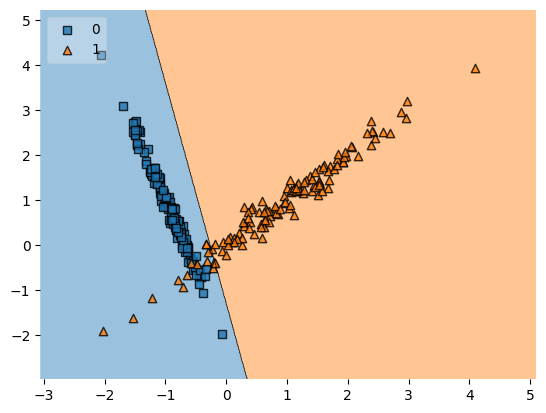

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
X, y = make_classification(n_samples=250, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X,y)
plot_decision_regions(X,y,clf=svm_linear, legend=2)

plt.show()

In [ ]:
shape_X = X.shape
shape_X_test = X_test.shape

num_rows_X, num_columns_X = shape_X
num_rows_X_test, num_columns_X_test = shape_X_test

print("Dimensions of X:")
print("Number of rows:", num_rows_X)
print("Number of columns:", num_columns_X)

print("\nDimensions of X_test:")
print("Number of rows:", num_rows_X_test)
print("Number of columns:", num_columns_X_test)

Dimensions of X:
Number of rows: 250
Number of columns: 2

Dimensions of X_test:
Number of rows: 80266
Number of columns: 5


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     17604
           0       0.39      1.00      0.56     31115
           1       0.00      0.00      0.00     31547

    accuracy                           0.39     80266
   macro avg       0.13      0.33      0.19     80266
weighted avg       0.15      0.39      0.22     80266



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

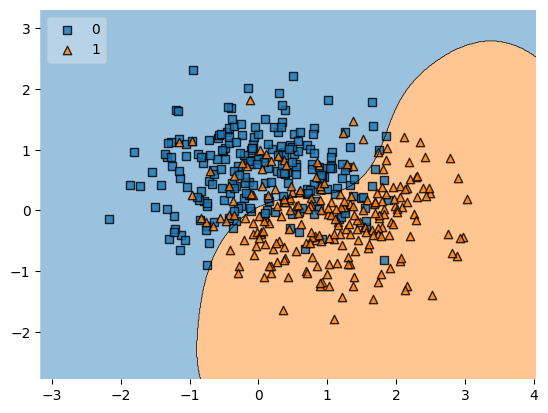

In [ ]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

X,y = make_moons(n_samples=450, noise=0.5, random_state=42)
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X,y)
plot_decision_regions(X,y,clf=svm, legend=2)

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Transform the dataset X_test using PCA
X_test_pca = pca.fit_transform(X_test)

# Predict the target variable y_test using the SVM model
y_pred = svm.predict(X_test_pca)
print(classification_report(y_test,y_pred))
plt.show()
# colors = ['maroon', 'forestgreen']
# plt.scatter(X[:,0], X[:,1], c=y, marker='.')
# plt.show()

In [ ]:
X_test_pca

array([[ 4.20833837e+03,  1.04757393e+02],
       [ 2.81833948e+06,  1.30078946e+03],
       [ 4.20833837e+03,  1.04757391e+02],
       ...,
       [-7.18135962e+06, -2.94917623e+03],
       [ 2.81833948e+06,  1.30078946e+03],
       [ 2.81833948e+06,  1.30078946e+03]])

In [ ]:
# linreg = LinearRegression()
# linreg = linreg.fit(X_train, y_train)

# y_pred = tree_model.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# # prec = precision_score(y_test, y_pred)
# report = classification_report(y_test,y_pred)

# print(acc)
# print(report)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(X)
# scaled_data = scaler.transform(X)

# model = LogisticRegression()
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)
# report = classification_report(y_test,y_pred)

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = LogisticRegression()

# y_pred = model.predict(X_test)


# acc = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
